In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import yaml
import pandas as pd
import os
from collections import Counter
import numpy as np
from torch.utils.data import DataLoader
from sklearn.preprocessing import quantile_transform 
from x_transformers import XTransformer, TransformerWrapper, Decoder, Encoder, ViTransformerWrapper
from dataset import DNASequenceDataSet
from model import DNATransformerEncoder, get_model
from training_utils import train_model, validate_model, test_model
from data_utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
with open('config.yaml', 'r') as stream:
    try:
        cfg = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [3]:
df = load_and_preprocess_enrichment_data(cfg)


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [4]:
df = pd.read_hdf('dna_dataset.h5', 'df')

In [5]:
df

,Sequence,Normalized_Frequency
0,ATCGGGGGGTGGGTTTGGGTATGGGGTCTGCACTATGGCTC,1.0
1,TCGCGGGGGGCGGGTCGGGTGCTCGTTCGAGGGGTCGCAG,1.0
2,AGGTTGGTGTAGGTTTAGGTTGTATTGGTTAGGGTTGAGA,1.0
3,TGGCTGTCTTACGATCGCGAAGGACGATTGAAAACTTTGA,0.0
4,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,1.0
...,...,...
1287745,AAGGCTTATCGGCTGGGGGGTGGGCCCGGGTTTGGGGTCGT,0.0
1287746,GGGCGCGGGCCGCCCCGGCCACACCAAAACACGTTCAGCT,0.0
1287747,GGGGGTTGCCGCCCCGGGCCACACCAAAACACGTTCAACT,0.0
1287748,TGGGGGGGGGGGTTTGGTTATGGGGTCCGCACTGTGGCTC,1.0


array([[<Axes: title={'center': 'Normalized_Frequency'}>]], dtype=object)

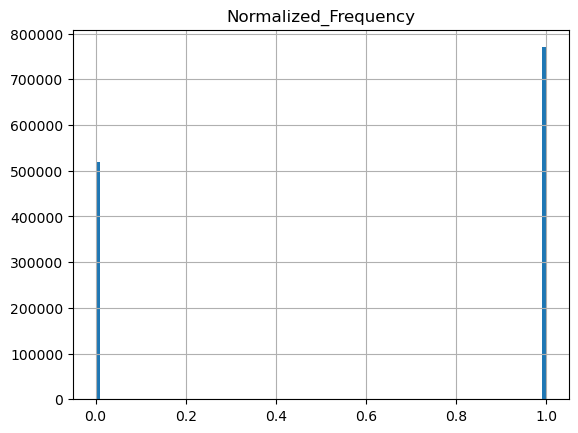

In [6]:
df.hist(column='Normalized_Frequency', bins=100)

In [7]:
dna_data  = DNASequenceDataSet(df)

In [70]:
model.device

device(type='cuda', index=0)

In [73]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cfg['device'] = device

model = get_model(cfg).to(device)

src = dna_data.x[:5].to(device)

len_x = dna_data.len_x[:5]
trg = dna_data.y[:5]



In [75]:


out = model(src, len_x) 


In [77]:
out.shape

torch.Size([5, 1])

<Axes: >

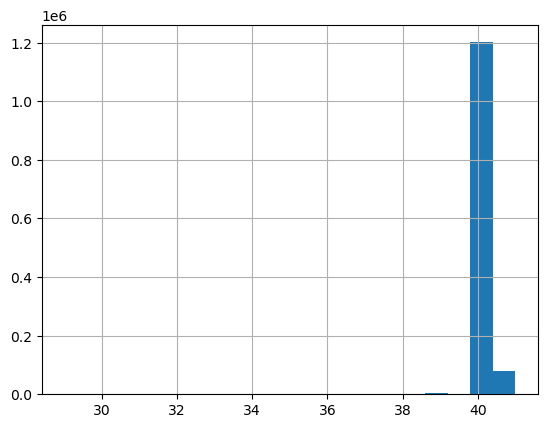

In [23]:
df['Sequence'].apply(len).hist(bins=20)

In [14]:
dataset = DNASequenceDataSet(df)

In [27]:
len(dataset.y.unique())

152611

array([[<Axes: title={'center': 'Normalized_Frequency'}>]], dtype=object)

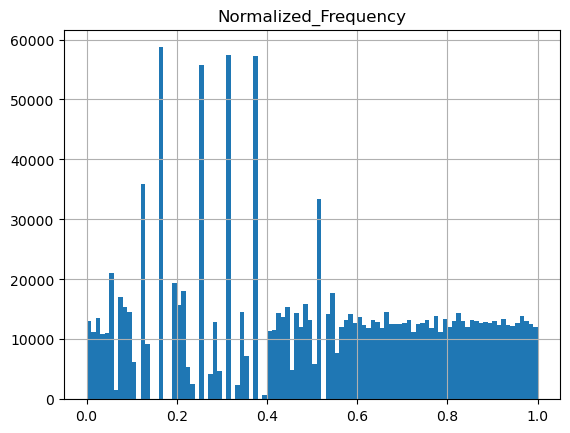

In [13]:
df.hist(column='Normalized_Frequency', bins=100)

In [ ]:
# Initialize the model and optimizer here as you did during training
device = torch.device("cuda:0")  
cfg.update({
    'device': device,
})

model = DNATransformerEncoder(cfg).to(device)
optimizer = optim.Adam(model.parameters(), lr=cfg['learning_rate'])

# Load the checkpoint
checkpoint = torch.load("model_checkpoint.pt")  # Replace X with the epoch number

# Restore the model and optimizer states
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Move the model to evaluation mode if you are doing inference
model.eval()


In [ ]:
import random

def generate_random_dna_sequence(length=40):
    nucleotides = ['A', 'C', 'G', 'T']
    return ''.join(random.choice(nucleotides) for _ in range(length))

# Generate a random DNA sequence of 40 nucleotides

n_sequences = 1000000

random_dna_sequence_data_set = [(generate_random_dna_sequence(), 1) for _ in range(n_sequences)]
df = pd.DataFrame(random_dna_sequence_data_set, columns=['Sequence', 'Normalized_Frequency'])
dna_dataset = DNASequenceDataSet(df)
test_loader = DataLoader(dna_dataset, batch_size=2048, num_workers=10)

In [ ]:
result = []
with torch.no_grad():
    for batch in test_loader:
        x, y, len_x = batch
        x = x.to(cfg['device'])
        
        output = model(x, len_x)
        
        result.append(output)

In [ ]:
best_random_sequence = torch.sort(torch.cat(result).movedim(1,0))

In [ ]:
best_random_sequence

In [ ]:
sorted(result, reverse=True)

In [ ]:
def get_min_max_normalized_frequency(combined_counter):
    # Extract the raw frequencies
    raw_frequencies = np.array(list(combined_counter.values()))
    
    # Calculate Min-Max normalization constants
    min_val = np.min(raw_frequencies)
    max_val = np.max(raw_frequencies)
    
    # Perform Min-Max normalization
    normalized_frequencies = {key: (value - min_val) / (max_val - min_val) for key, value in combined_counter.items()}
    
    # Sort by normalized frequency
    sorted_items = sorted(normalized_frequencies.items(), key=lambda item: item[1], reverse=True)
    
    return sorted_items

def load_and_preprocess_data(dfs):
    
    counter_set = Counter(dfs)
    sorted_normalized_items = get_min_max_normalized_frequency(counter_set)
    df = pd.DataFrame(sorted_normalized_items, columns=['Sequence', 'Normalized_Frequency'])
    return df

df = load_and_preprocess_data(df)
df

In [ ]:
load_and_preprocess_data(cfg)